In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import collections
import math
import pandas as pd
import copy

If you want the result to be reproducible, you will need to set the seed.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Mount to Google drive and unpack your dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#import shutil
shutil.unpack_archive("/content/drive/MyDrive/Deep Learning/ISIC_balanced_split.zip", "/content/drive/MyDrive/Deep Learning/")

Run calculation on mean and standard deviation of my train dataset.

This is an additional code to check the mean and standard deviation of your dataset - you can then use it to replace the values in transforms.Normalize to improve your work.


In [ ]:
train_data = datasets.ImageFolder(root = '/content/drive/My Drive/Deep Learning/ISIC_balanced_split/train/',
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.6938, 0.5495, 0.5302])
Calculated stds: tensor([0.1293, 0.1447, 0.1579])


Image resizing and image augmentation

In [ ]:
# set batch size to 32
batch_size = 32

transform_train = transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height-to-width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new 224 x 224 image
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    # Randomly change the brightness, contrast, and saturation
    transforms.ColorJitter(brightness=0.4,
                                        contrast=0.4,
                                        saturation=0.4),
    # Add random noise
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.1),

    # Standardize each channel of the image
    #transforms.Normalize([0.485, 0.456, 0.406],
    #                                 [0.229, 0.224, 0.225])
    transforms.Normalize([0.6938, 0.5495, 0.5302],[0.1293, 0.1447, 0.1579])
   ])

transform_test = transforms.Compose([
    transforms.Resize((32,32)),
    # Crop a 224 x 224 square area from the center of the image
    #torchvision.transforms.CenterCrop(32),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406],
    #                                 [0.229, 0.224, 0.225])
    transforms.Normalize([0.6938, 0.5495, 0.5302],[0.1293, 0.1447, 0.1579])
   ])

Reading the dataset

In [ ]:
data_dir = '/content/drive/My Drive/Deep Learning/ISIC_balanced_split/'

train_ds, train_valid_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_train) for folder in ['train', 'valid']]

valid_ds, test_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_test) for folder in ['valid', 'ISIC2017_test']]

In [ ]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

Show image - display some of your images for observation.

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

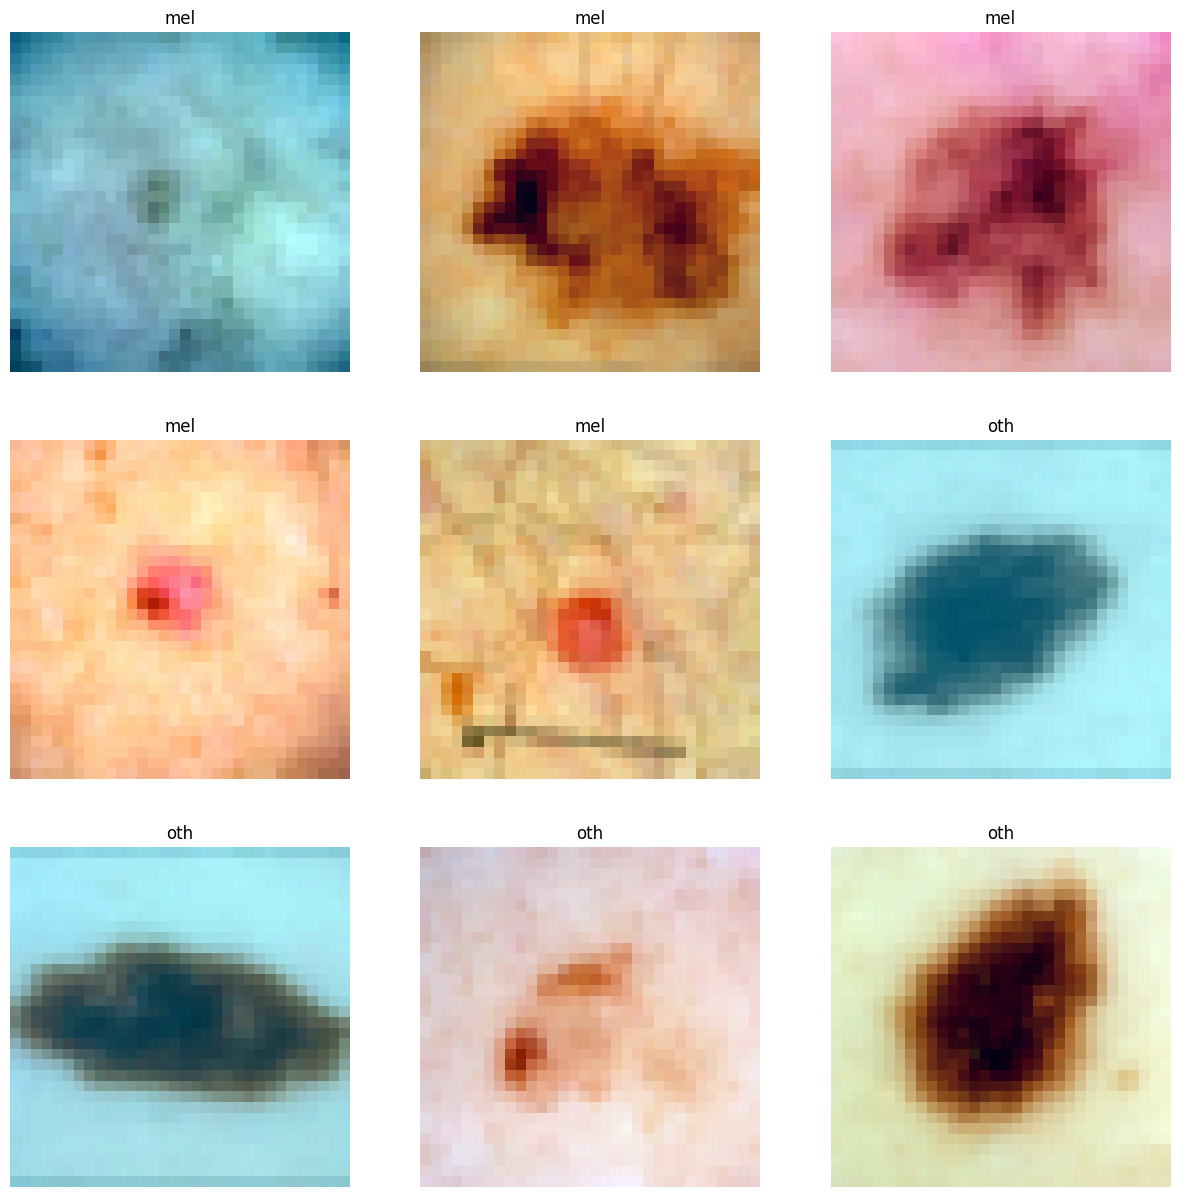

In [ ]:
N_IMAGES = 10
j=int(len(train_ds)/2) - int(N_IMAGES/2)

images, labels = zip(*[(image, label) for image, label in
                           [train_ds[i+j] for i in range(N_IMAGES)]])

classes = train_ds.classes

plot_images(images, labels, classes)

Define the CNN - this example will focus on AlexNet.

In [ ]:
class ViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768, num_heads=12, num_layers=12, output_dim=2):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_dim = in_channels * patch_size * patch_size
        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.positional_embeddings = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim)* 0.02)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)* 0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model= embed_dim,
            nhead=num_heads,
            dim_feedforward= embed_dim * 4,
            dropout=0.1,
            activation='gelu'
        )

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, output_dim)
        )

    def forward(self, x):
        patches = self.patch_embed(x)
        patches = patches.flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        tokens = torch.cat((cls_tokens, patches), dim=1)
        tokens += self.positional_embeddings[:, :tokens.size(1), :]
        tokens = tokens.permute(1, 0, 2)
        encoded = self.transformer(tokens)

        cls_output = encoded[0]
        logits = self.mlp_head(cls_output)

        return logits




HERE you can adjust the number of classes

In [ ]:
OUTPUT_DIM = 2

model = ViT(img_size=224, patch_size=16, in_channels=3, embed_dim=768, num_heads=12, num_layers=12, output_dim=OUTPUT_DIM)

def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

model.apply(initialize_parameters)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ViT(
  (patch_embed): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mlp_head): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=2, bias=True)
  )
)

This is to display the number of trainable parameters.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 85,800,194 trainable parameters


Setting the hyperparameters and train the model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-4

optimizer = optim.Adam(model.parameters(), lr=CHOSE_LR)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
!pip install early-stopping-pytorch
from early_stopping_pytorch import EarlyStopping

early_stopping = EarlyStopping(patience=7, verbose=True)

EPOCHS = 20 # You may need to run longer to get better results. Lab example is for demo only

# keeping-track-of-losses
train_losses = []
valid_losses = []

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iter, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')

    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.673896).  Saving model ...
Epoch: 01 | Epoch Time: 1m 13s
	Train Loss: 0.814 | Train Acc: 58.15%
	 Val. Loss: 0.674 |  Val. Acc: 71.52%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Validation loss decreased (0.673896 --> 0.553766).  Saving model ...
Epoch: 02 | Epoch Time: 1m 14s
	Train Loss: 0.637 | Train Acc: 64.99%
	 Val. Loss: 0.554 |  Val. Acc: 74.18%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Epoch: 03 | Epoch Time: 1m 10s
	Train Loss: 0.592 | Train Acc: 70.92%
	 Val. Loss: 0.580 |  Val. Acc: 73.98%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Validation loss decreased (0.553766 --> 0.540005).  Saving model ...
Epoch: 04 | Epoch Time: 1m 10s
	Train Loss: 0.565 | Train Acc: 71.94%
	 Val. Loss: 0.540 |  Val. Acc: 72.80%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Validation loss decreased (0.540005 --> 0.517059).  Saving model ...
Epoch: 05 | Epoch Time: 1m 14s
	Train Loss: 0.560 | Train Acc: 72.45%
	 Val. Loss: 0.517 |  Val. Acc: 75.36%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Epoch: 06 | Epoch Time: 1m 8s
	Train Loss: 0.579 | Train Acc: 70.78%
	 Val. Loss: 0.577 |  Val. Acc: 70.85%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 7
Epoch: 07 | Epoch Time: 1m 7s
	Train Loss: 0.587 | Train Acc: 71.29%
	 Val. Loss: 0.548 |  Val. Acc: 74.49%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 7
Epoch: 08 | Epoch Time: 1m 11s
	Train Loss: 0.593 | Train Acc: 71.57%
	 Val. Loss: 0.580 |  Val. Acc: 73.10%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

EarlyStopping counter: 4 out of 7
Epoch: 09 | Epoch Time: 1m 8s
	Train Loss: 0.629 | Train Acc: 67.76%
	 Val. Loss: 0.588 |  Val. Acc: 72.28%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

EarlyStopping counter: 5 out of 7
Epoch: 10 | Epoch Time: 1m 9s
	Train Loss: 0.638 | Train Acc: 65.15%
	 Val. Loss: 0.625 |  Val. Acc: 62.04%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

EarlyStopping counter: 6 out of 7
Epoch: 11 | Epoch Time: 1m 9s
	Train Loss: 0.666 | Train Acc: 60.93%
	 Val. Loss: 0.641 |  Val. Acc: 66.29%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

EarlyStopping counter: 7 out of 7
Early stopping triggered


Example code to plot losses.

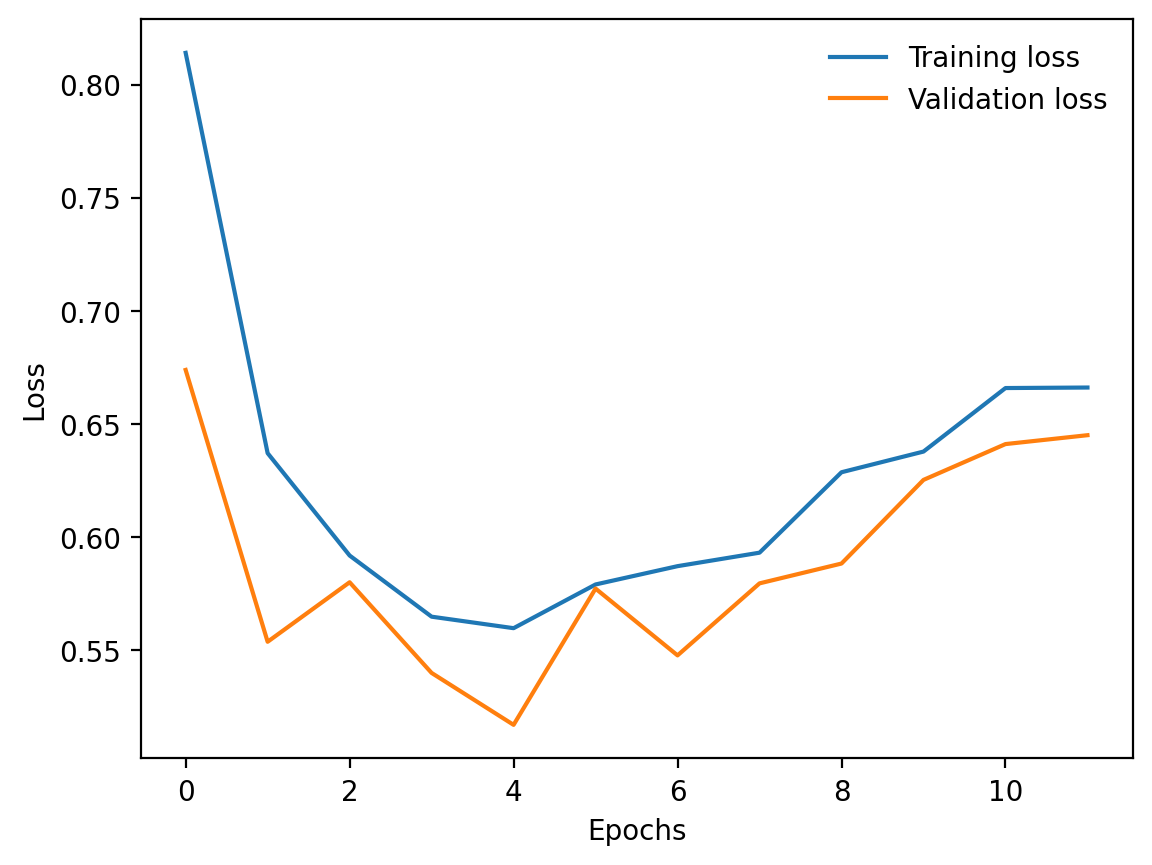

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred= model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs



Loading the best model

In [ ]:
# model.load_state_dict(torch.load('best-model.pt'))

In [ ]:
images, labels, probs = get_predictions(model, test_iter, device)

In [ ]:
test = pd.read_csv('/content/drive/My Drive/Deep Learning/ISIC_balanced_split/ISIC2017_Test_GroundTruth.csv')
y_test = np.array(test.drop(['id'], axis=1))

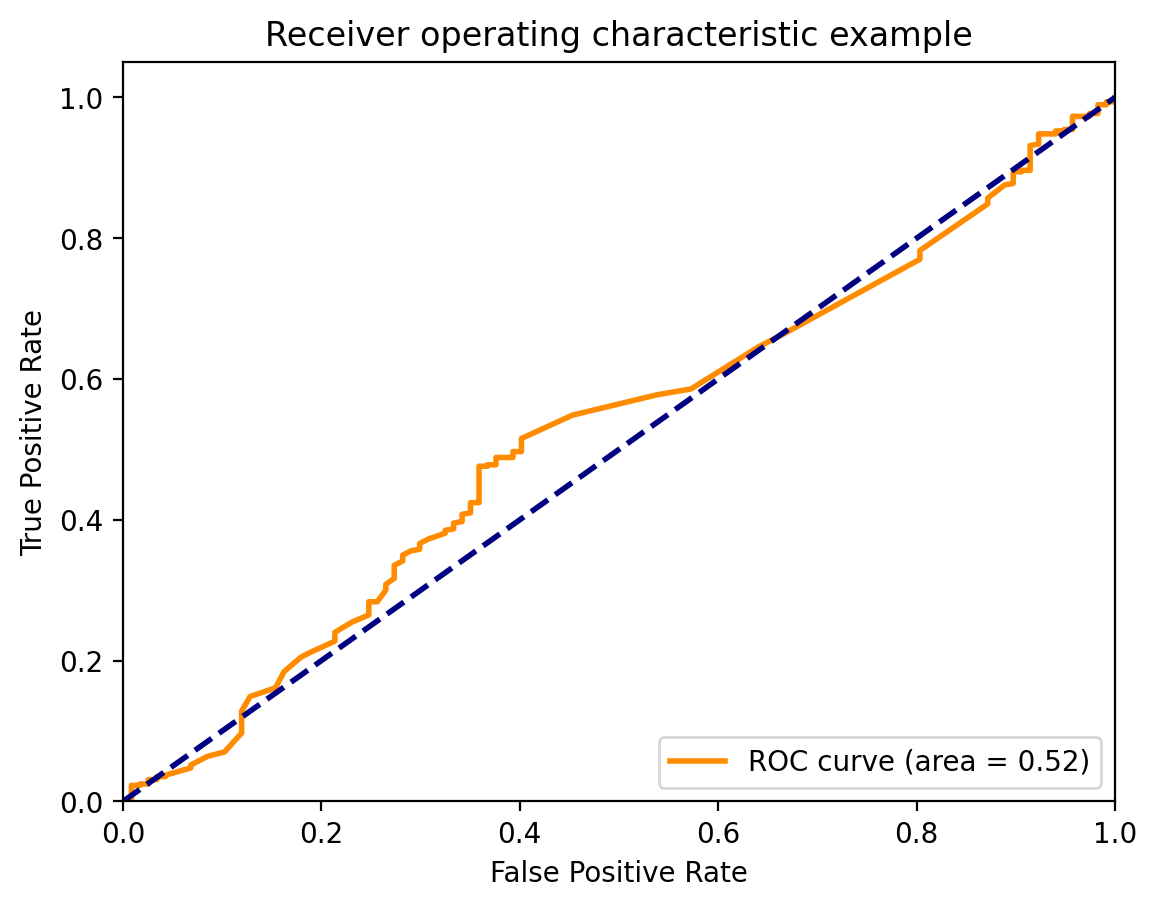

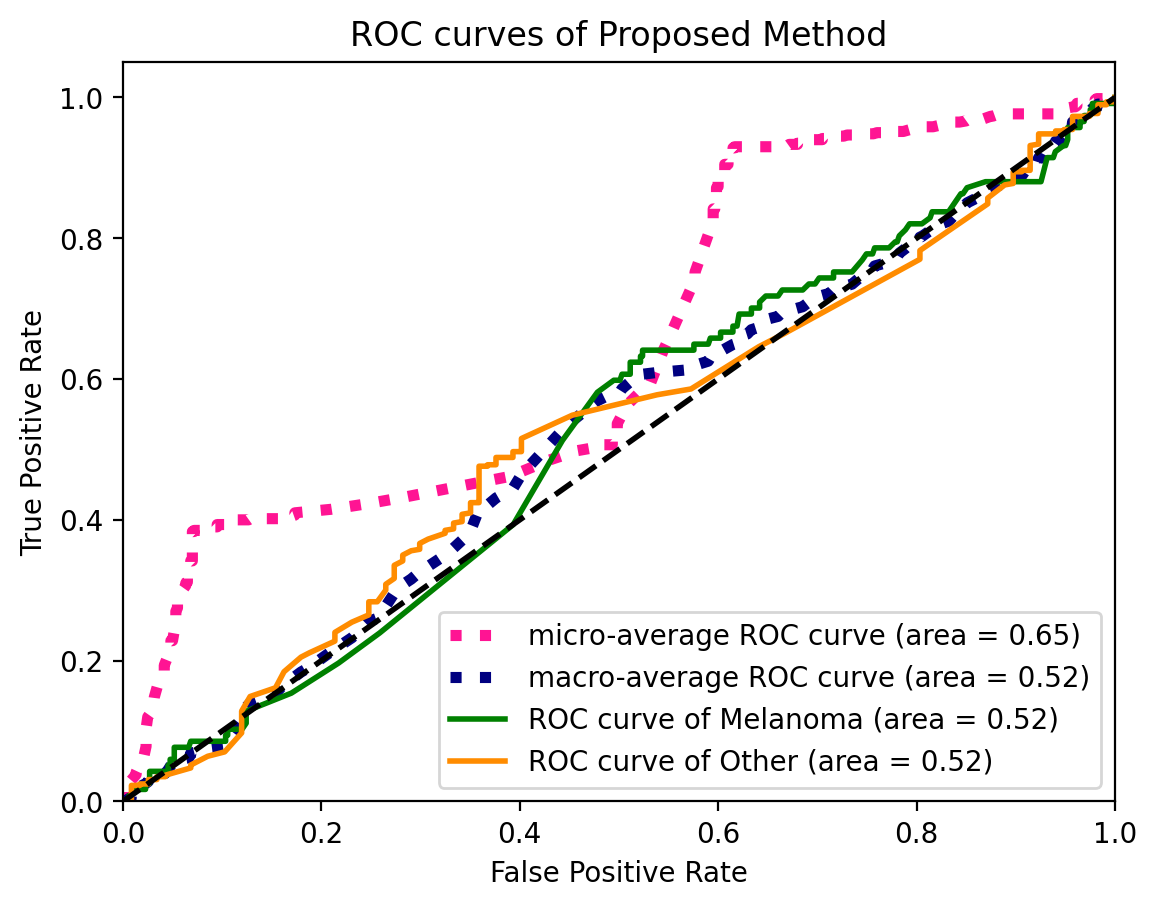

In [ ]:
from itertools import cycle
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
#change to OneVsOneClassifier for generalized AUC
#from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
#from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

n_classes=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr[0], tpr[0], color='green', lw=lw,
         label='ROC curve of Melanoma (area = {1:0.2f})'
         ''.format(0, roc_auc[0]))

plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw,
         label='ROC curve of Other (area = {1:0.2f})'
         ''.format(1, roc_auc[1]))

# if you need more classes
# plt.plot(fpr[2], tpr[2], color='red', lw=lw,
#          label='ROC curve of third class (area = {1:0.2f})'
#          ''.format(1, roc_auc[2]))

# plt.plot(fpr[3], tpr[3], color='cornflowerblue', lw=lw,
#          label='ROC curve of fourth class (area = {1:0.2f})'
#          ''.format(1, roc_auc[3]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of Proposed Method')
plt.legend(loc="lower right")
plt.show()

[[ 73  44]
 [252 231]]
[0 1]
[117 483]
[[117. 117.]
 [483. 483.]]


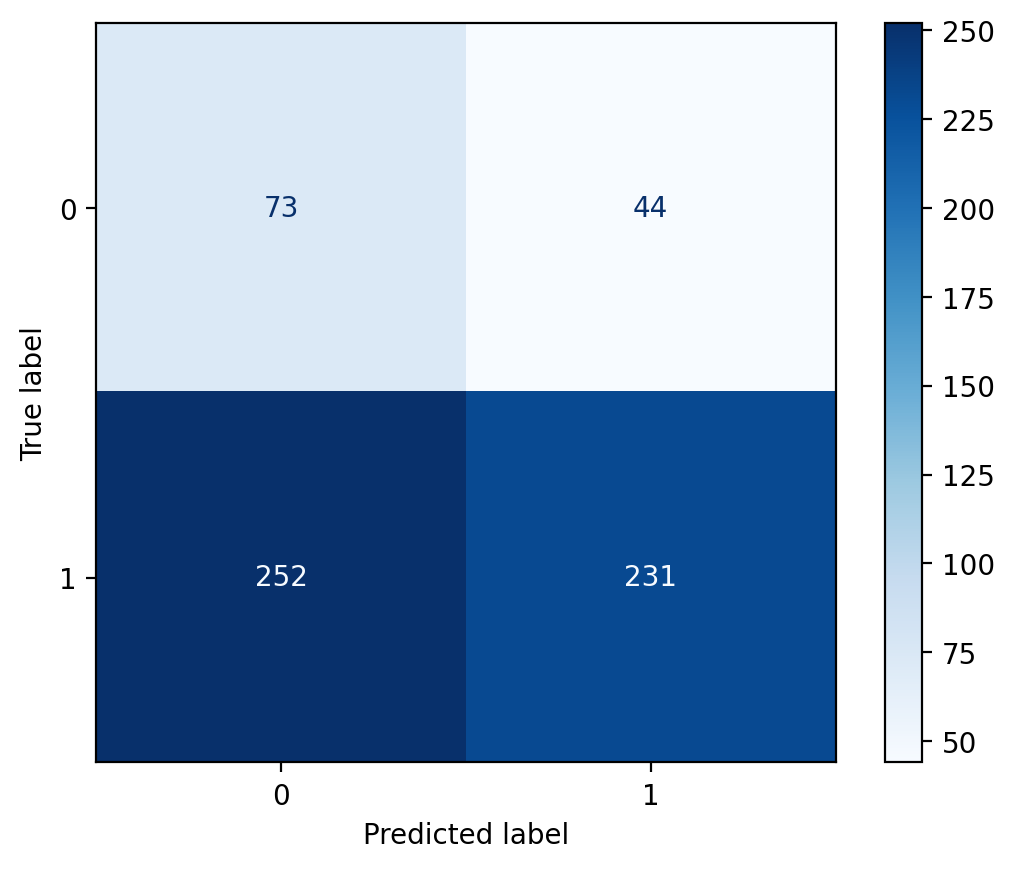

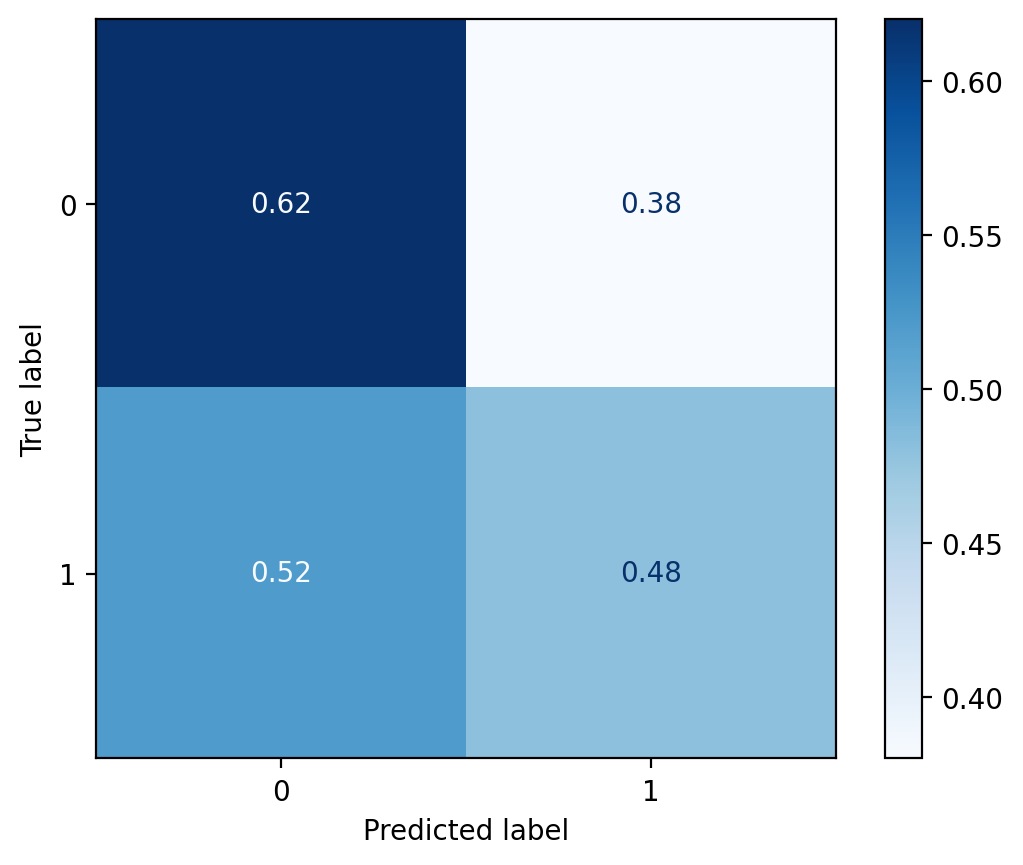

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import Normalize
from sklearn.metrics import ConfusionMatrixDisplay

pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)

cm=confusion_matrix(true_class, pred_class)
class_names = unique_labels(true_class, pred_class)
print(cm)
print(class_names)

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

C = cm
divisor = np.zeros((2,2))
divisor[0][:] = 117
divisor[1][:] = 483
cm_normalised=np.divide(cm, divisor)
print(np.transpose(C.sum(axis=1)))
print(divisor)
cm_normalised = np.round(cm_normalised, 2)
disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='')

In [ ]:
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP

precision_per_class = TP / (TP + FP)
recall_per_class = TP / (TP + FN)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

weights = cm.sum(axis=1) / cm.sum()
precision_weighted = np.sum(precision_per_class * weights)
recall_weighted = np.sum(recall_per_class * weights)
f1_weighted = np.sum(f1_per_class * weights)


print(f"Precision (Weighted): {precision_weighted:.2f}")
print(f"Recall (Weighted): {recall_weighted:.2f}")
print(f"F1-score (Weighted): {f1_weighted:.2f}")

Precision (Weighted): 0.72
Recall (Weighted): 0.51
F1-score (Weighted): 0.56
